In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# from statsmodels.stats.outliers_influence import variance_inflation_factor

0.85 needed

# Reading Datasets

In [2]:
df_train = pd.read_csv("/kaggle/input/fraud-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/fraud-detection/test.csv")

In [3]:
Y = df_train["isFraud"]
df_train.drop(labels=["isFraud"], axis = 1, inplace=True) #We drop transaction ID because it is unique for each and every row and doesn't provides any essential information.

In [4]:
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

# oversample = RandomOverSampler(sampling_strategy='minority')
# # fit and apply the transform
# df_train, Y = oversample.fit_resample(df_train, Y)
# # summarize class distribution
# # print(Counter(y_over))

In [5]:
train_df = pd.concat([df_train.assign(ind="train"), test_df.assign(ind="test")])

In [6]:
train_df.drop(labels=["TransactionID"], axis = 1, inplace=True) #We drop transaction ID because it is unique for each and every row and doesn't provides any essential information.
train_df.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind
0,11053717,49.00,W,5033,269.0,150.0,mastercard,224.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
1,5150800,57.95,W,4527,376.0,150.0,visa,226.0,debit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
2,10713596,115.95,W,2772,512.0,150.0,visa,226.0,debit,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train
3,1611950,100.00,H,14290,512.0,150.0,visa,226.0,debit,177.0,...,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows,train
4,6111087,95.00,W,12839,321.0,150.0,visa,226.0,debit,220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train


In [7]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
train_df['DT_M'] = train_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
train_df['DT_M'] = (train_df['DT_M'].dt.year-2017)*12 + train_df['DT_M'].dt.month 

# X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
# X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month

In [8]:
train_df['DT_M']

0         16
1         13
2         16
3         12
4         14
          ..
147630    13
147631    15
147632    17
147633    17
147634    12
Name: DT_M, Length: 590540, dtype: int64

# Dropping Columns

In [9]:
Empty_col_train = []
SameValue_col_train = []
MaxSameValue_col_train = []

for f in train_df.columns :
    if train_df[f].isna().sum()/len(train_df) >= 0.9 :
        Empty_col_train.append(f)
    if train_df[f].nunique() <= 1 :
        SameValue_col_train.append(f)
    if train_df[f].value_counts(dropna=False, normalize=True).values[0] >= 0.9 :
        MaxSameValue_col_train.append(f)



In [10]:
cols_tobedropped = list(set(Empty_col_train+SameValue_col_train+MaxSameValue_col_train))
# cols_tobedropped = Empty_col_train

train_df.drop(cols_tobedropped, axis=1, inplace=True)
test_df.drop(cols_tobedropped, axis=1, inplace=True)

### Categorical and numerical features sorting


In [11]:
def cat_num_features(df): 
    cat_cols = []
    numer_cols = []
    
    # Given Categorical Features 
    cat_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2','M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','DeviceType', 'DeviceInfo']
    cat_cols+=["id_12", "id_15", "id_16", "id_23", "id_27", "id_28", "id_29", "id_30", "id_31", "id_33", "id_34", "id_35", "id_36", "id_37", "id_38"]


    # Updating the Categorical Feature Names List based on the columns present in the dataframe
    cat_cols = [feature for feature in cat_cols if feature in df.columns.values]
    numer_cols = [feature for feature in df.columns if feature not in cat_cols]
    
    return (cat_cols, numer_cols) 

In [12]:
cat_cols, numer_cols = cat_num_features(train_df)
categorical_feature_indices = [train_df.columns.get_loc(f) for f in cat_cols]

In [13]:
numer_cols.remove("ind")
# cat_cols.remove("DeviceInfo")

### Removing Inter-Dependent Features

We have group of attributes for id(12 -38), C(1-15), D(1-16) and V(1-339). Some of the attributes in their groups are inter-dependent and thus we can remove some of the attributes from that particular group. To do this, we will make use of VIF values (Variance Inflation Factor).
A variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. 

# C Features

In [14]:
c_features = ["C"+str(i) for i in range(1,15) if "C"+str(i) in train_df.columns]

In [15]:
# Create correlation matrix
corr_matrix = train_df[c_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

# Drop features 
train_df.drop(to_drop, axis=1, inplace=True)
for i in to_drop:
    numer_cols.remove(i)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


# V-features

In [16]:
v_features = ["V"+str(i) for i in range(1,340) if "V"+str(i) in train_df.columns]


In [17]:
v_features

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V99',
 'V100',
 'V126',
 'V127',
 'V128',
 'V130',
 'V131',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',


In [18]:
# we will take all columns and group them based on missing percentage
nan_dict = {}
for col in v_features:
    count = df_train[col].isnull().sum()
    try:
        nan_dict[count].append(col)
    except:
        nan_dict[count] = [col]
        
for k,v in nan_dict.items():
    print(f'#####' * 4)
    print(f'NAN count = {k} percent: {(int(k)/df_train.shape[0])*100} %')
    print(v)

####################
NAN count = 209495 percent: 47.300211106219166 %
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
####################
NAN count = 56964 percent: 12.861448843431436 %
['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
####################
NAN count = 126693 percent: 28.605005588105804 %
['V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52']
####################
NAN count = 57701 percent: 13.027850216186316 %
['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
####################
NAN count = 66794 percent: 15.080886420338446 %
['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']

# V1-V11

In [19]:
def reduce_groups(grps):
    '''
    determining column that have more unique values among a group of atttributes
    '''
    use = []
    for col in grps:
        max_unique = 0
        max_index = 0
        for i,c in enumerate(col):
            n = df_train[c].nunique()
            if n > max_unique:
                max_unique = n
                max_index = i
        use.append(col[max_index])
    return use

In [20]:
def coorelation_analysis(cols,title='Coorelation Analysis',size=(12,12)):
    cols = sorted(cols)
    fig,axes = plt.subplots(1,1,figsize=size)
    df_corr = train_df[cols].corr()
    sns.heatmap(df_corr,annot=True,cmap='RdBu_r')
    axes.title.set_text(title)
    plt.show()

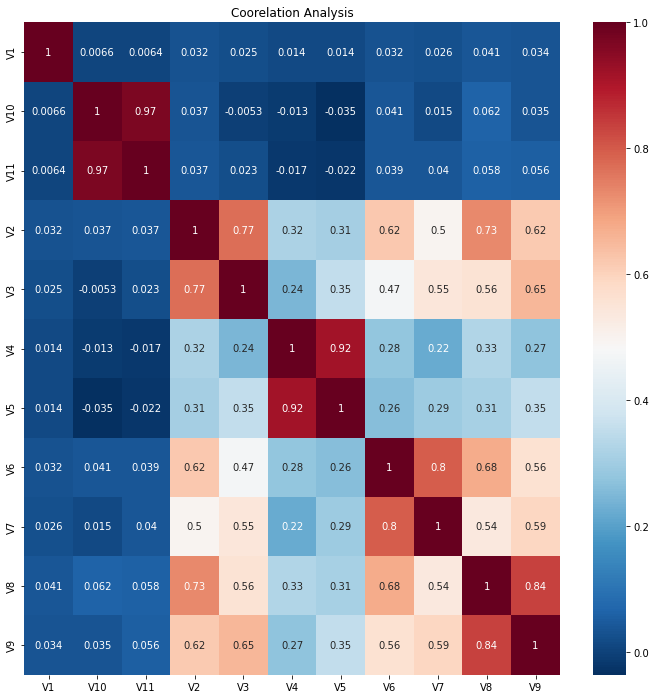

In [21]:
g1_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']
coorelation_analysis(g1_cols)

In [22]:
pairs = [['V1'], ['V2', 'V3'], ['V4', 'V5'], ['V6', 'V7'], ['V8', 'V9'], ['V10', 'V11']]
g1 = reduce_groups(pairs)
g1

['V1', 'V3', 'V4', 'V6', 'V9', 'V11']

# V12-V34

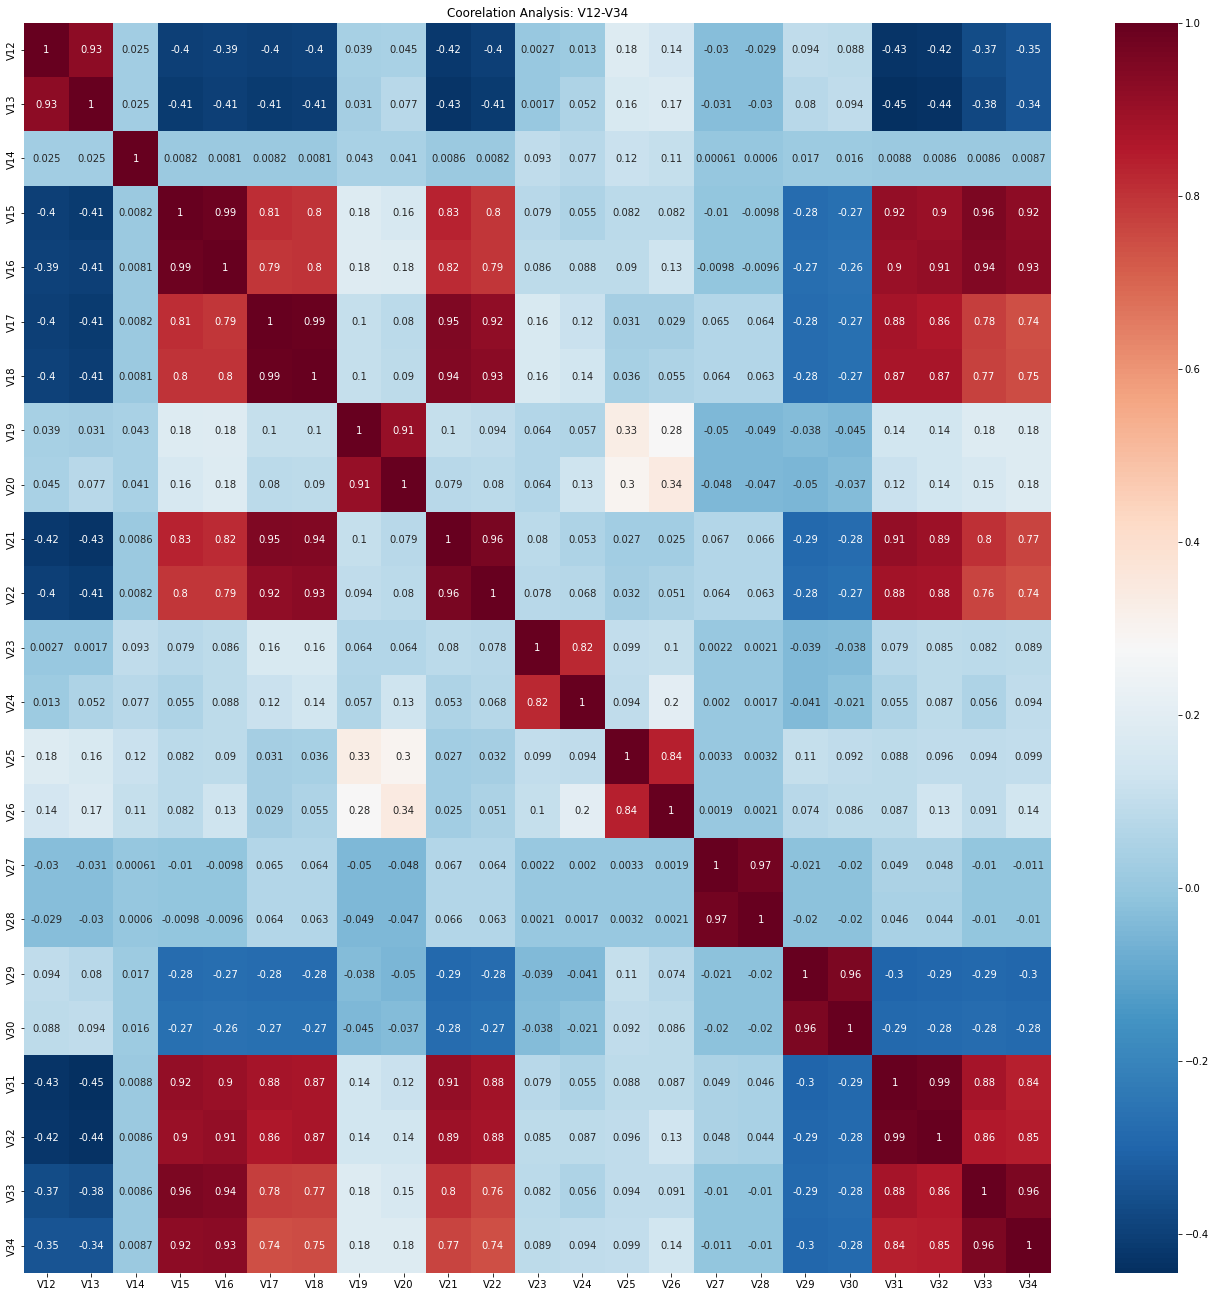

In [23]:
g2_cols = ['V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34']
coorelation_analysis(g2_cols, title='Coorelation Analysis: V12-V34',size=(len(g2_cols), len(g2_cols)))

In [24]:
pairs = [['V12','V13'],['V14'],['V15','V16','V17','V18','V21','V22','V31','V32','V33','V34'],['V19','V20'],['V23','V24'],['V25','V26'],['V27','V28'],['V29','V30']]

g2 = reduce_groups(pairs)
g2

['V13', 'V14', 'V17', 'V20', 'V23', 'V26', 'V27', 'V30']

# V35-V52

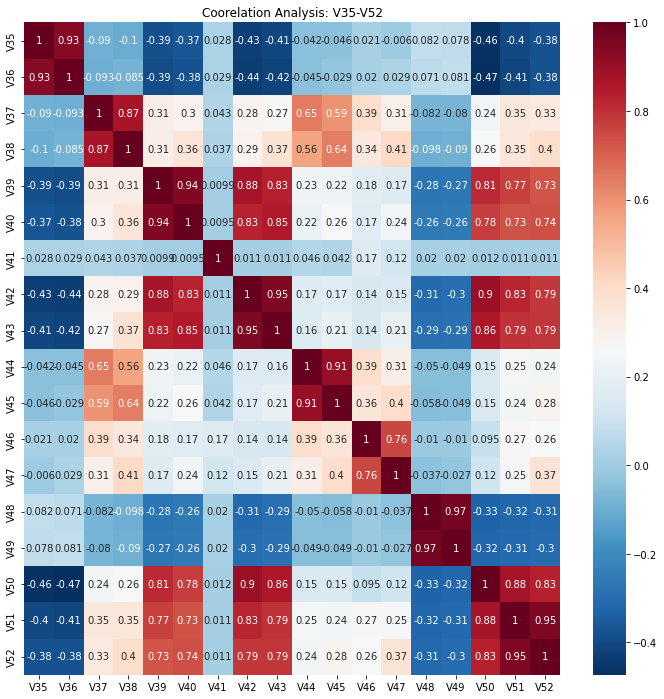

In [25]:
cols = ['V35', 'V40', 'V41', 'V39', 'V38', 'V51', 'V37', 'V52', 'V36', 'V50', 'V48', 'V42', 'V43', 'V44', 'V46', 'V47', 'V45', 'V49']
coorelation_analysis(cols,title='Coorelation Analysis: V35-V52',size=(12,12))

In [26]:
pairs = [['V35','V36'],['V37','V38'],['V39','V40','V42','V43','V50','V51','V52'],['V41'],
         ['V44','V45'],['V46','V47'],['V48','V49']]

g3 = reduce_groups(pairs)
g3

['V36', 'V38', 'V39', 'V41', 'V44', 'V47', 'V48']

# V53-V74

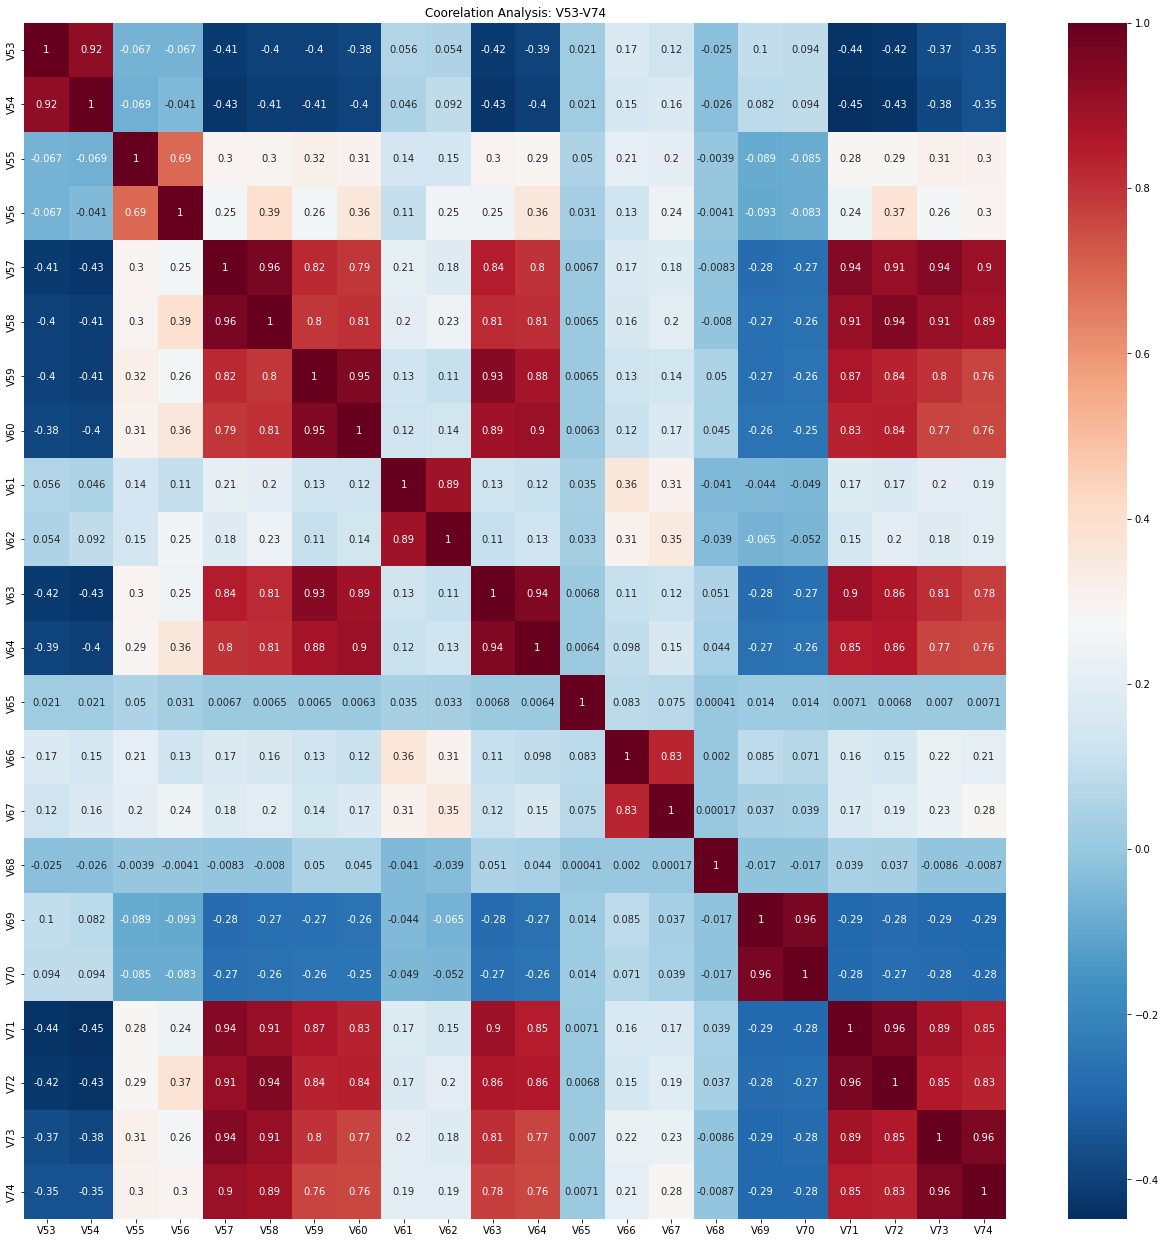

In [27]:
g4_cols = ['V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74']
coorelation_analysis(g4_cols,  title='Coorelation Analysis: V53-V74',size=(len(g4_cols), len(g4_cols)))

In [28]:
pairs = [['V53','V54'],['V55'],['V56'],['V57', 'V58', 'V59', 'V60', 'V63', 'V64', 'V71', 'V72', 'V73', 'V74'],['V61','V62'], ['V65'],['V66','V67'],['V68'],['V69','V70']]

g4 = reduce_groups(pairs)
g4

['V54', 'V55', 'V56', 'V59', 'V62', 'V65', 'V67', 'V68', 'V70']

# V75 - V94

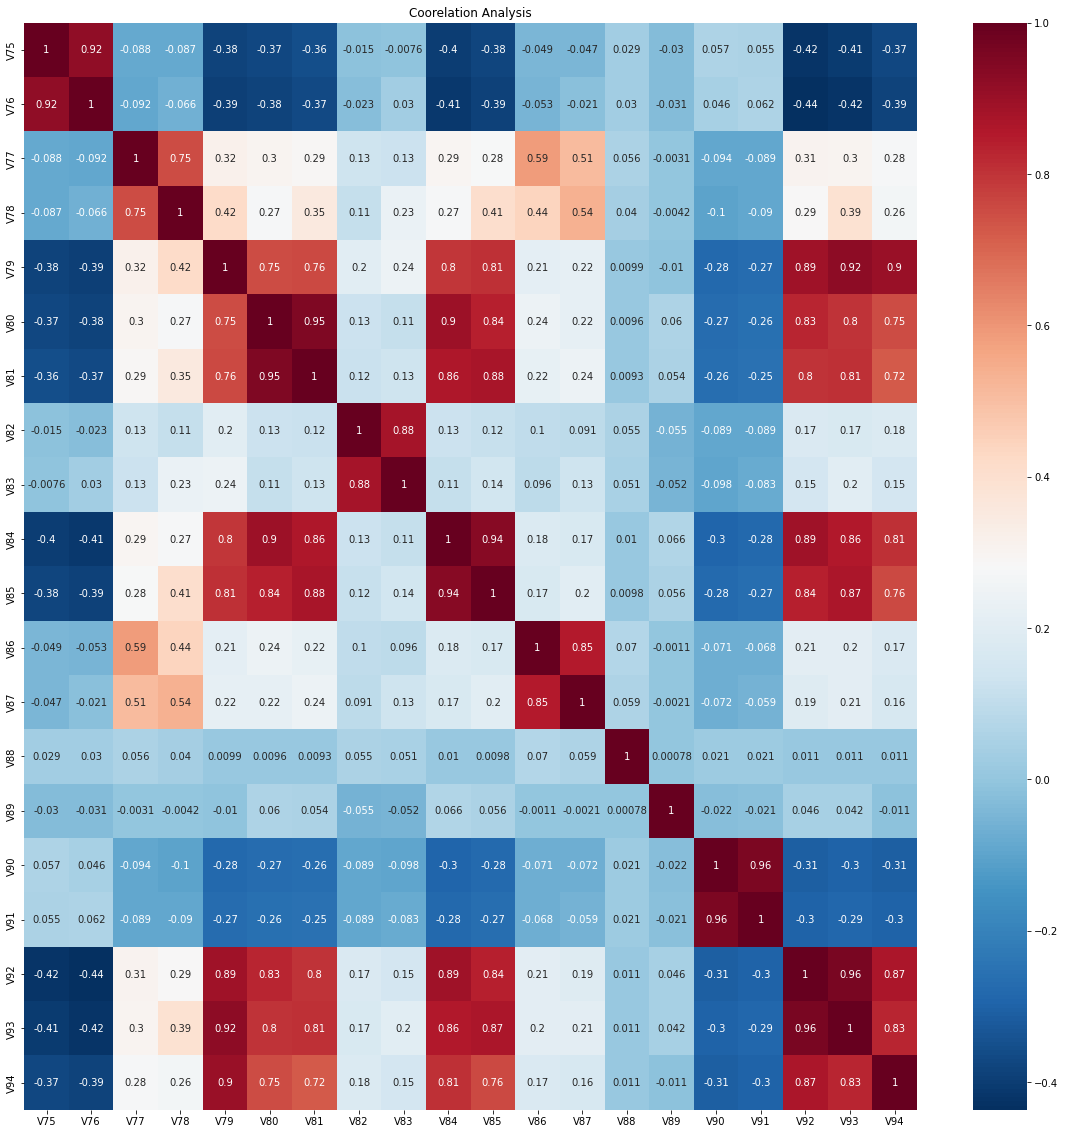

In [29]:
g5_cols = ['V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94']
coorelation_analysis(g5_cols, size=(len(g5_cols), len(g5_cols)))

In [30]:
pairs = [['V75','V76'],['V77','V78'],['V79','V80','V81','V84','V85','V92','V93','V94'],['V82','V83'],['V86','V87'], ['V88'],['V89'],['V90','V91']]

g5 = reduce_groups(pairs)
g5

['V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91']

# V95-V137

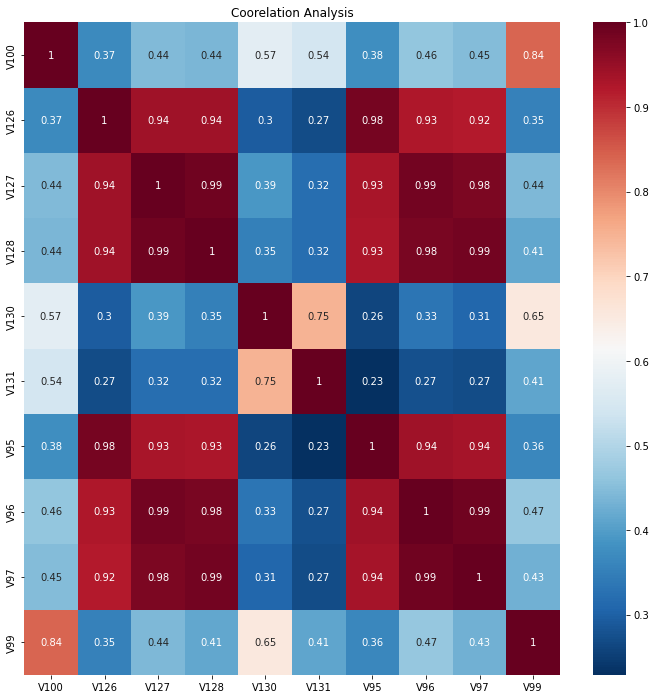

In [31]:
g6_cols = ['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131']
coorelation_analysis(g6_cols)

In [32]:
pairs = [['V100', 'V99'], ['V126', 'V127', 'V128', 'V95', 'V96', 'V97'], ['V130', 'V131']]
g6 = reduce_groups(pairs)
g6

['V99', 'V127', 'V130']

# V138 - V163

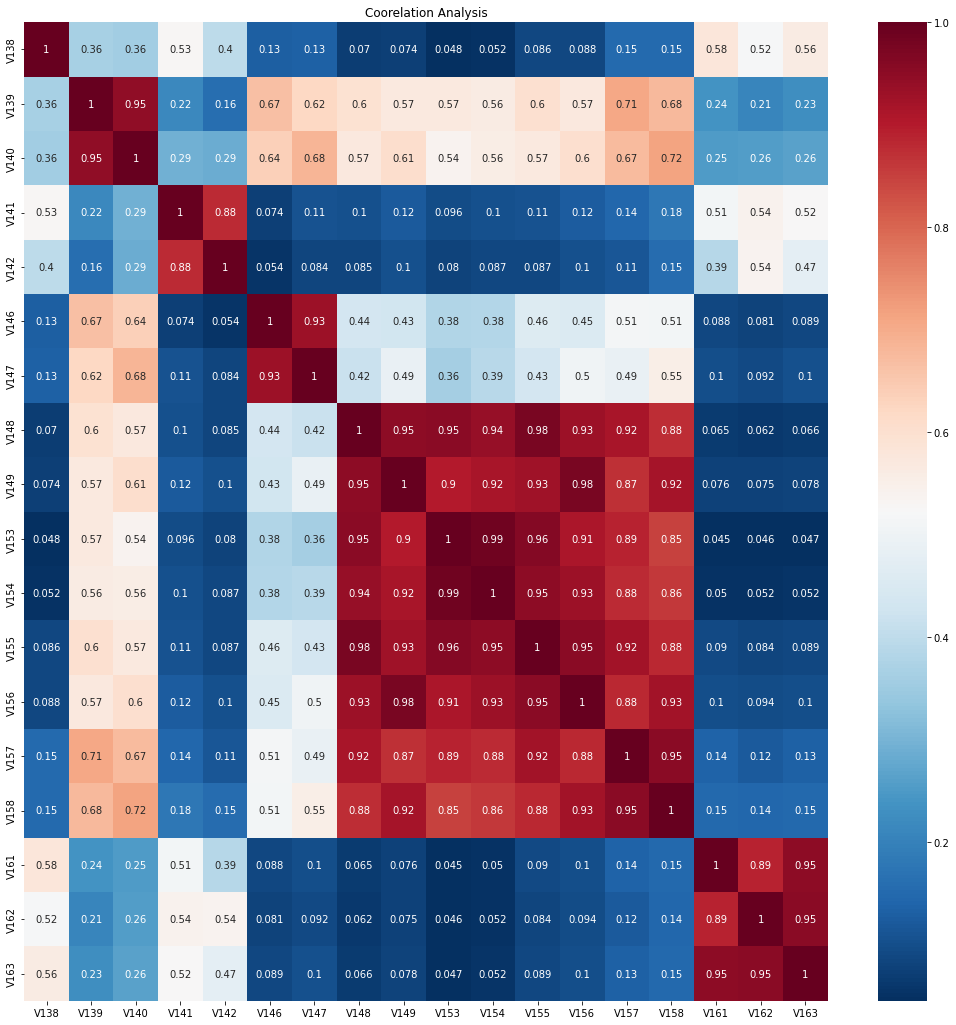

In [33]:
cols = ['V138', 'V139', 'V140', 'V141', 'V142', 'V146', 'V147', 'V148', 'V149', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V161', 'V162', 'V163']
coorelation_analysis(cols, size=(len(cols), len(cols)))

In [34]:
pairs = [['V138'],['V139','V140'],['V141','V142'],['V146','V147'],['V148','V149','V153','V154','V155', 'V156','V157','V158'],['V161','V162','V163']]

g13 = reduce_groups(pairs)
g13

['V138', 'V139', 'V142', 'V147', 'V155', 'V162']

# V143- V166

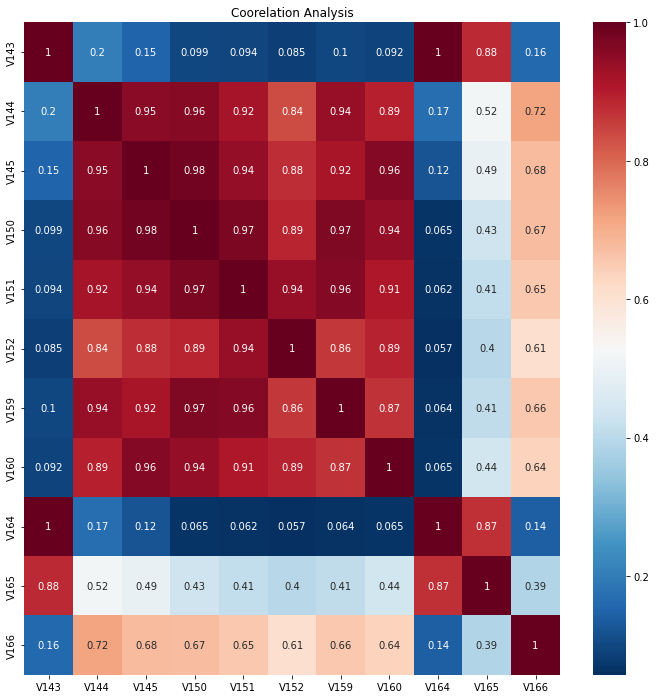

In [35]:
cols = ['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']
coorelation_analysis(cols)

In [36]:
pairs = [['V143','V164','V165'],['V144','V145','V150','V151','V152','V159','V160'],['V166']]

g14 = reduce_groups(pairs)
g14

['V165', 'V160', 'V166']

# V167 - V216

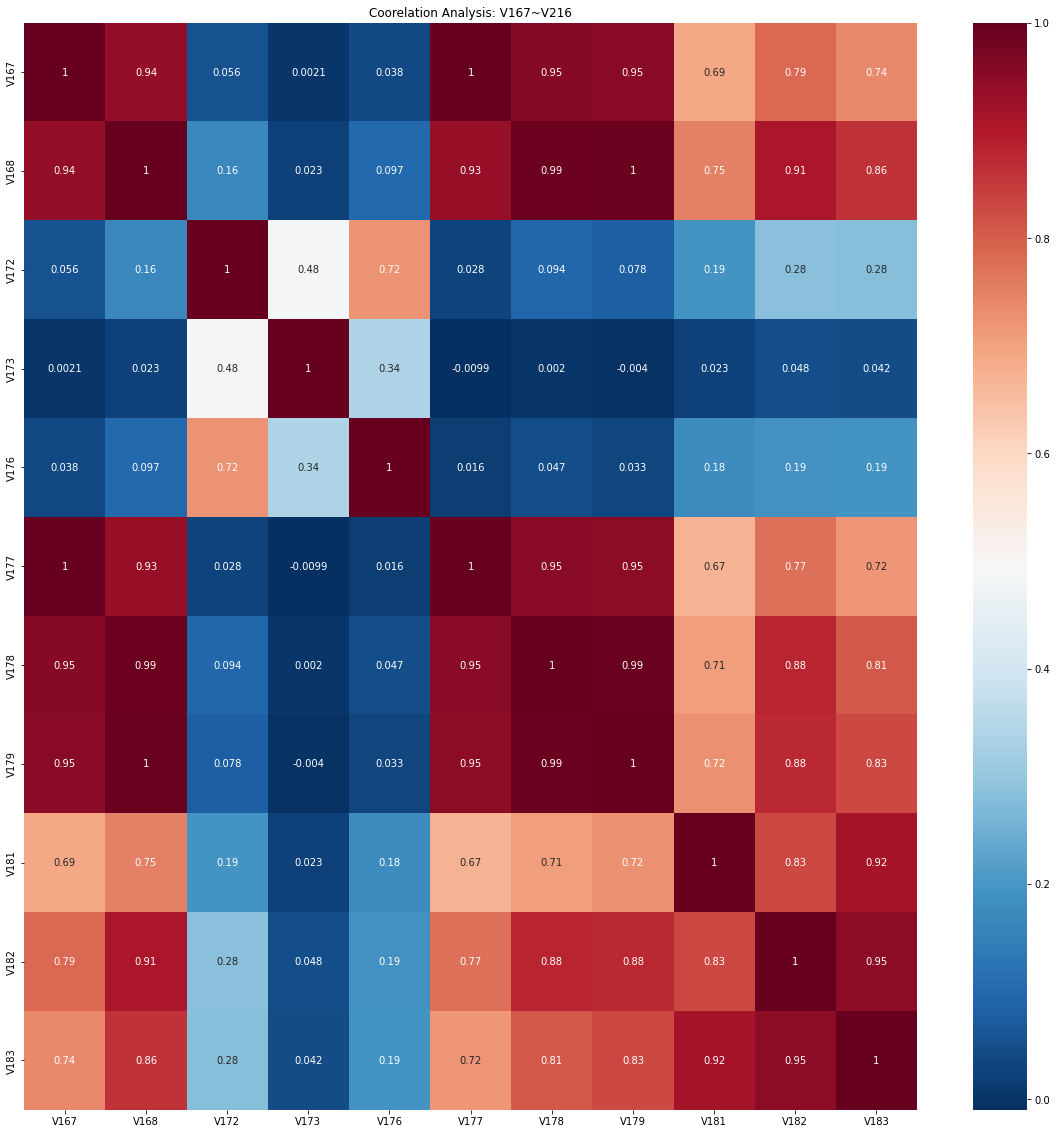

In [37]:
cols = ['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183'] #['V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']
coorelation_analysis(cols,title='Coorelation Analysis: V167~V216',size=(20,20))

In [38]:
pairs = [['V167','V168','V177','V178','V179'],['V172','V176'],['V173'],['V181','V182','V183']]
temp = reduce_groups(pairs)
temp

['V178', 'V176', 'V173', 'V182']

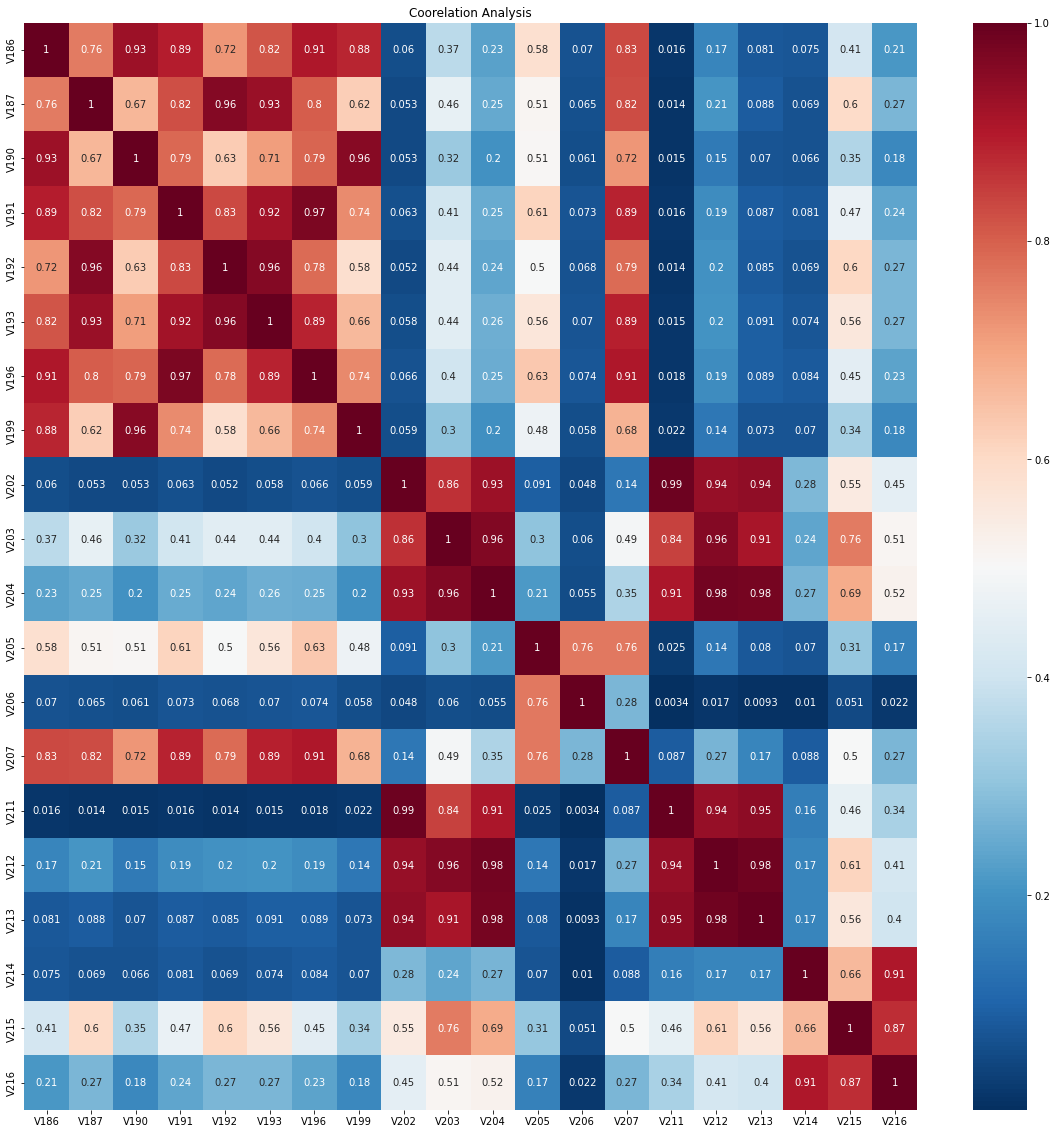

In [39]:
cols = ['V186','V187','V190','V191','V192','V193','V196','V199','V202','V203','V204','V211','V212','V213','V205','V206','V207','V214','V215','V216']

coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [40]:
pairs = [['V186','V187','V190','V191','V192','V193','V196','V199'],['V202','V203','V204','V211','V212','V213'],['V205','V206'],['V207'],['V214','V215','V216']]
temp1 = reduce_groups(pairs)
temp1

['V187', 'V203', 'V205', 'V207', 'V215']

In [41]:
g7 = temp+temp1
g7

['V178', 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215']

# V169 - V210

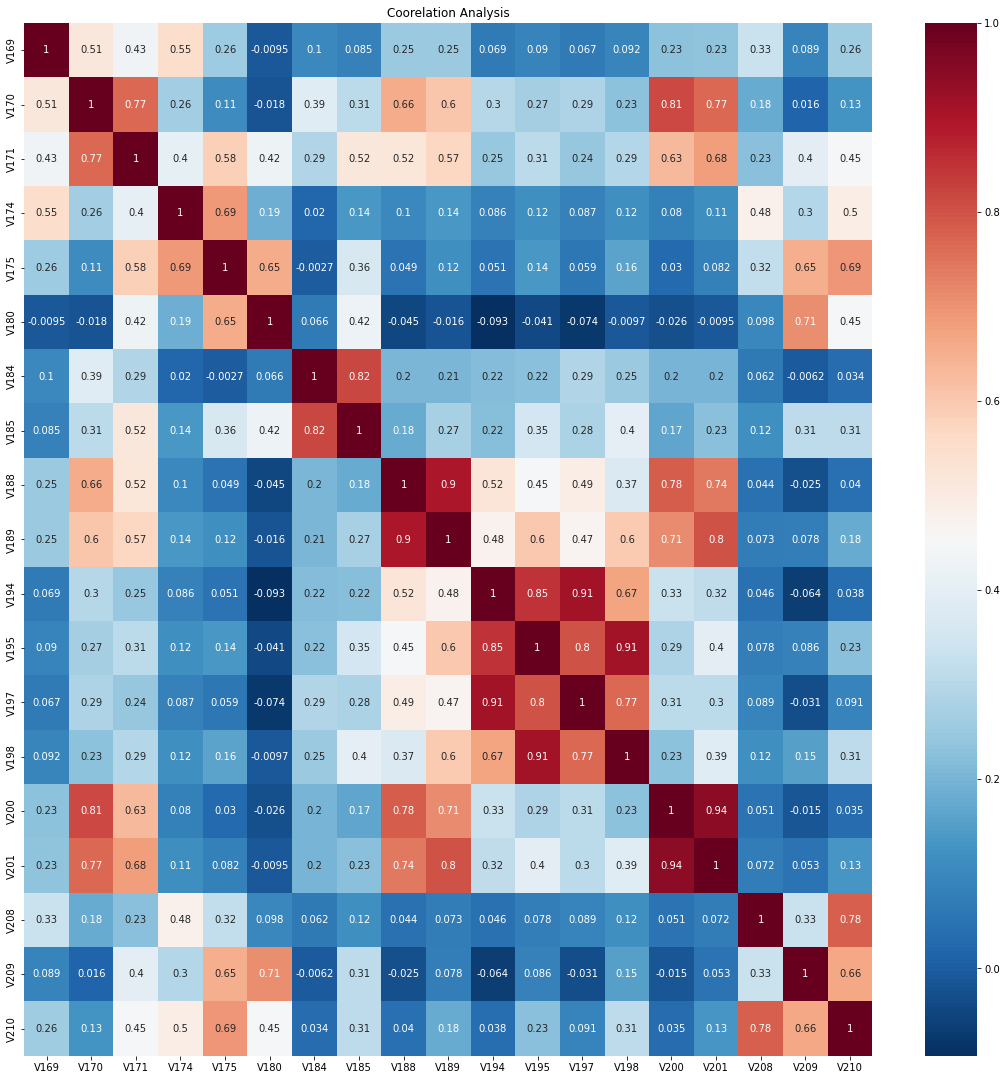

In [42]:
g8_cols = ['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']
coorelation_analysis(g8_cols, size = (len(g8_cols), len(g8_cols)))

In [43]:
pairs = [['V169'],['V170','V171','V200','V201'],['V174','V175'],['V180'],['V184','V185'],['V188','V189'],['V194','V195','V197','V198'],['V208','V210'], ['V209']]
g8 = reduce_groups(pairs)
g8

['V169', 'V171', 'V175', 'V180', 'V185', 'V188', 'V198', 'V210', 'V209']

# V217 - V278

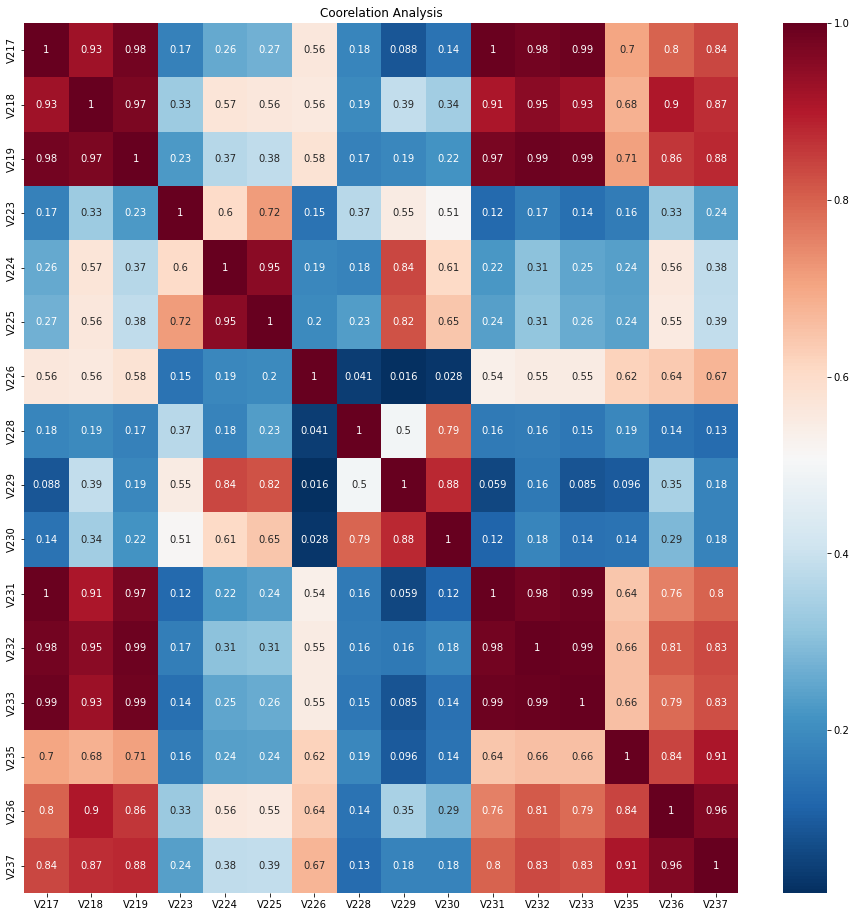

In [44]:
# cols = ['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']
cols = ['V217','V218','V219','V231','V232','V233','V236','V237','V223','V224','V225','V226','V228','V229','V230','V235']
coorelation_analysis(cols, size = (len(cols), len(cols)))

In [45]:
pairs = [['V217','V218','V219','V231','V232','V233','V236','V237'],['V223'],['V224','V225'],['V226'],['V228'],['V229','V230'],['V235']]
temp = reduce_groups(pairs)
temp

['V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235']

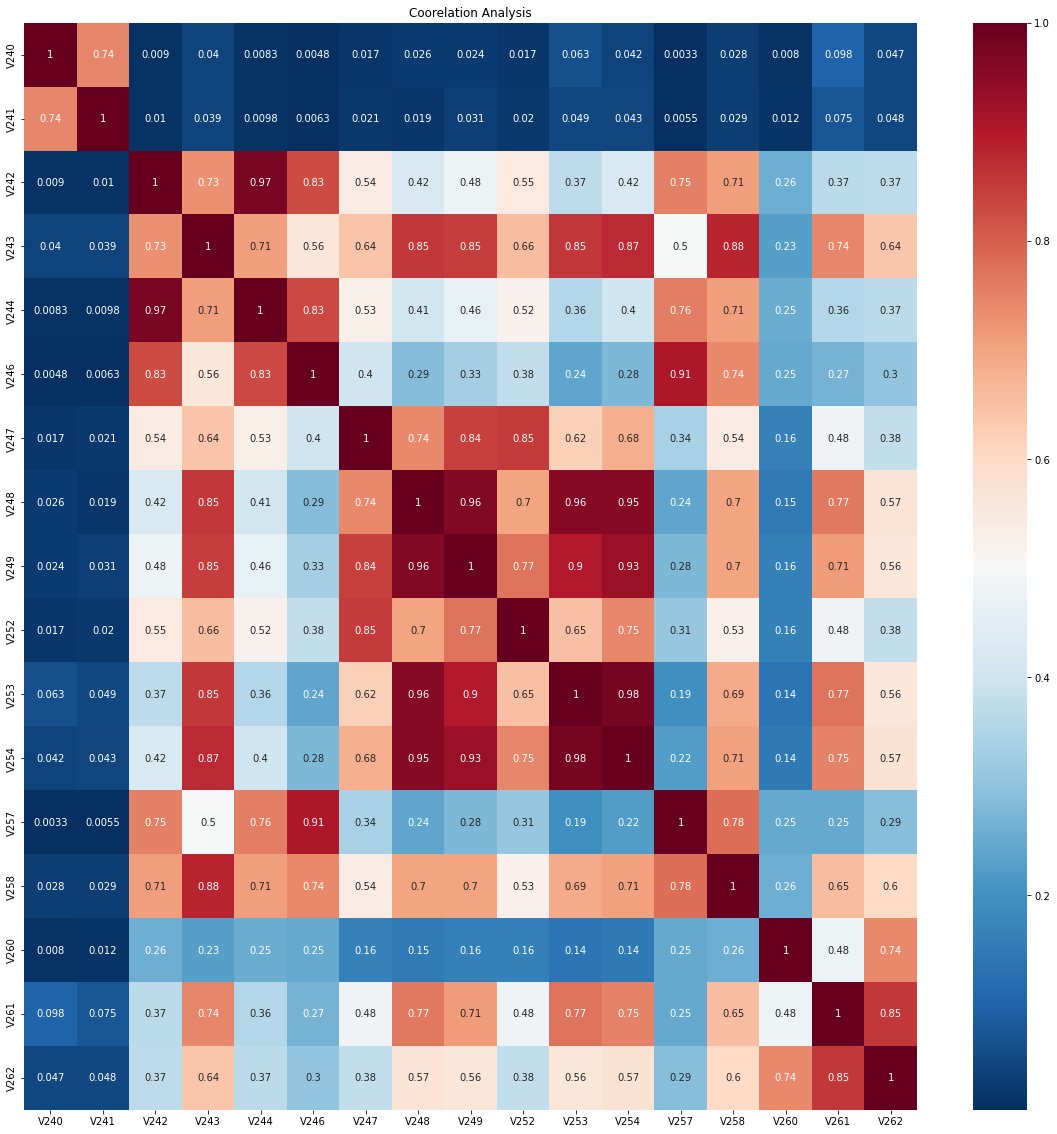

In [46]:
cols = ['V240','V241','V242','V243','V244','V258','V246','V257','V247','V248','V249','V253','V254','V252','V260','V261','V262']
coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [47]:
pairs = [['V240','V241'],['V242','V243','V244','V258'],['V246','V257'],['V247','V248','V249','V253','V254'],['V252'],['V260'],['V261','V262']]
temp1 = reduce_groups(pairs)
temp1

['V240', 'V258', 'V257', 'V253', 'V252', 'V260', 'V261']

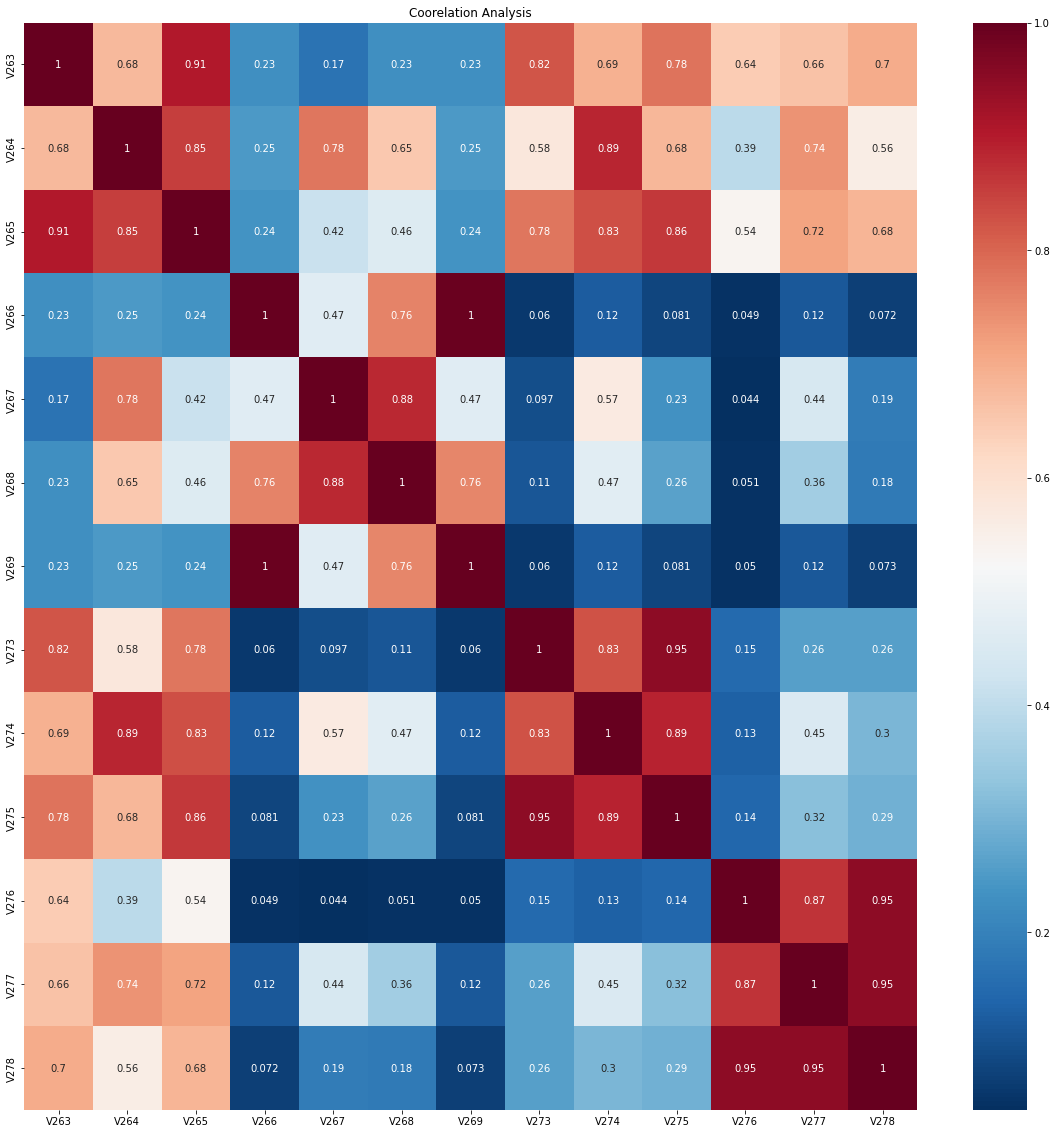

In [48]:
cols =  ['V263','V265','V264','V266','V269','V267','V268','V273','V274','V275','V276','V277','V278']
coorelation_analysis(cols,title='Coorelation Analysis',size=(20,20))

In [49]:
pairs =[['V263','V265','V264'],['V266','V269'],['V267','V268'],['V273','V274','V275'],['V276','V277','V278']]
temp2 = reduce_groups(pairs)
temp2

['V264', 'V266', 'V267', 'V274', 'V277']

In [50]:
g9 = temp+temp1+temp2
g9

['V218',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V235',
 'V240',
 'V258',
 'V257',
 'V253',
 'V252',
 'V260',
 'V261',
 'V264',
 'V266',
 'V267',
 'V274',
 'V277']

# V220 - V272

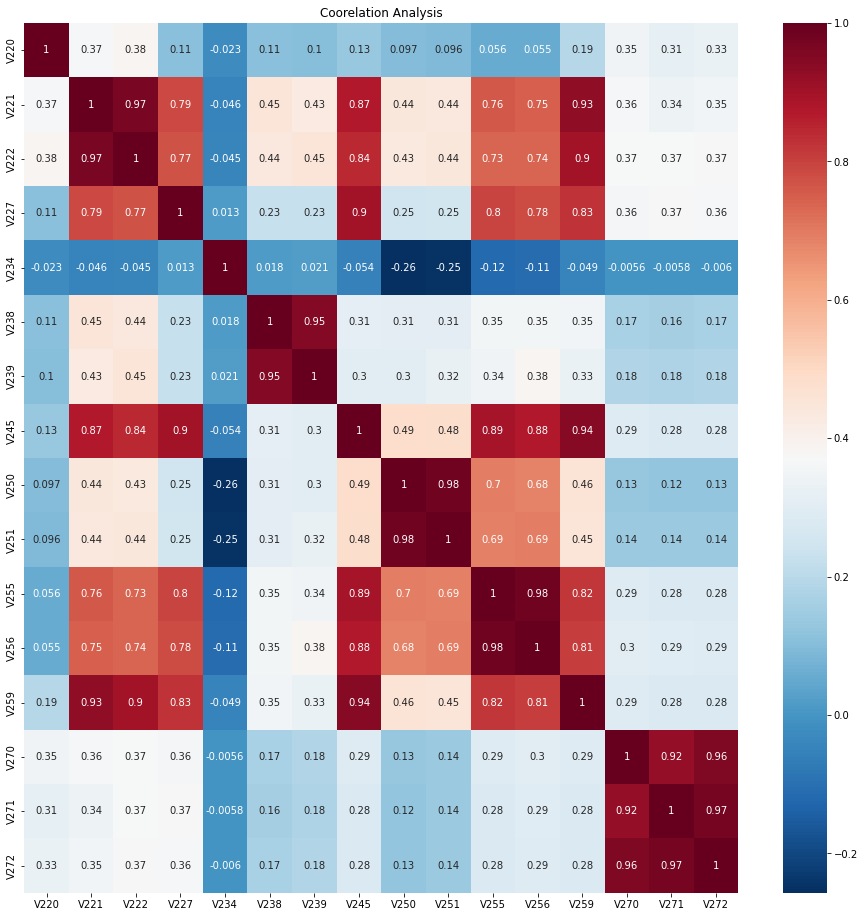

In [51]:
g10_cols = ['V220', 'V221', 'V222', 'V227', 'V234', 'V238', 'V239', 'V245', 'V250', 'V251', 'V255', 'V256', 'V259', 'V270', 'V271', 'V272']
coorelation_analysis(g10_cols, size = (len(g10_cols), len(g10_cols)))

In [52]:
pairs = [['V220'],['V221','V222','V227','V245','V255','V256','V259'],['V234'],['V238','V239'],['V250','V251'],['V270','V271','V272']]
g10 = reduce_groups(pairs)
g10

['V220', 'V222', 'V234', 'V238', 'V250', 'V271']

# G11

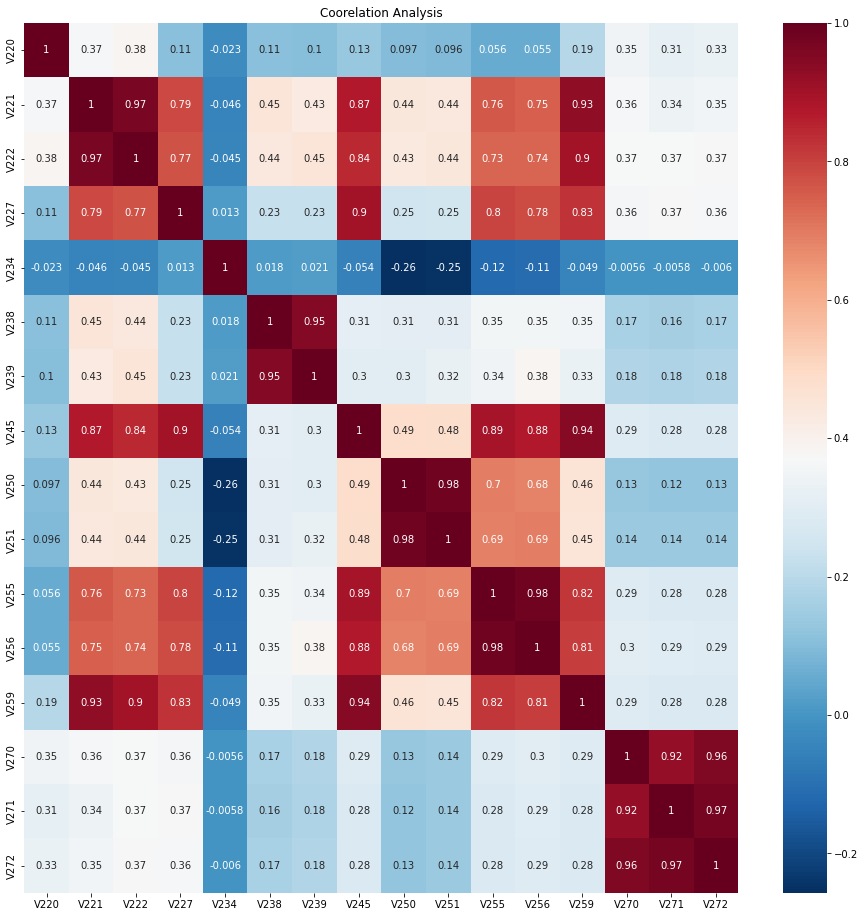

In [53]:
g11_cols = ['V279', 'V280', 'V285', 'V287', 'V291', 'V292', 'V294', 'V302', 'V303', 'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V317']
coorelation_analysis(g10_cols, size = (len(g10_cols), len(g10_cols)))

In [54]:
pairs = [['V279', 'V280', 'V294', 'V306', 'V307', 'V308', 'V317'], ['V285', 'V287'], ['V291', 'V292'], ['V302', 'V303', 'V304'], ['V310', 'V312']]
g11 = reduce_groups(pairs)
g11

['V307', 'V285', 'V291', 'V303', 'V310']

# G12

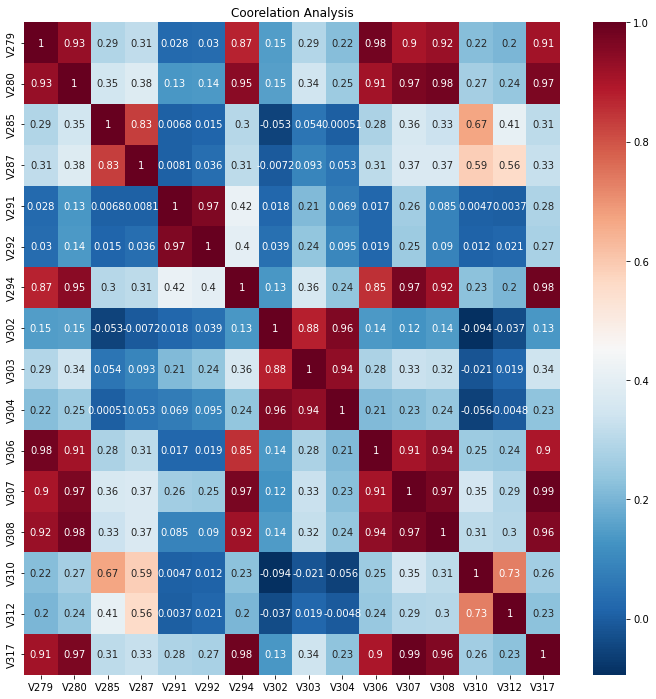

In [55]:
g12_cols = ['V282', 'V283', 'V288', 'V289', 'V313', 'V314', 'V315']
coorelation_analysis(g11_cols)

In [56]:
pairs = [['V282', 'V283'], ['V288', 'V289'], ['V313', 'V314', 'V315']]
g12 = reduce_groups(pairs)
g12

['V283', 'V289', 'V314']

In [57]:
reduced_V_cols = g1+g2+g3+g4+g5+g6+g7+g8+g9+g10+g11+g12+g13+g14
# reduced_V_cols

In [58]:
V_features = [i for i in train_df.columns if i[0]=='V']
# V_features

In [59]:
not_V_red = [i for i in V_features if i not in reduced_V_cols]

In [60]:
train_df.drop(labels = not_V_red, axis = 1, inplace = True)

### Dropping C, D Features based on Backward Feature Selection


In [61]:
train_df.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind,DT_M
0,11053717,49.00,W,5033,269.0,150.0,mastercard,224.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,16
1,5150800,57.95,W,4527,376.0,150.0,visa,226.0,debit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,13
2,10713596,115.95,W,2772,512.0,150.0,visa,226.0,debit,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,16
3,1611950,100.00,H,14290,512.0,150.0,visa,226.0,debit,177.0,...,1920x1080,match_status:2,T,F,T,T,desktop,Windows,train,12
4,6111087,95.00,W,12839,321.0,150.0,visa,226.0,debit,220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,14


# D features

In [62]:
d_features = ["D"+str(i) for i in range(1,15) if "D"+str(i) in train_df.columns]

In [63]:
# Create correlation matrix
corr_matrix = train_df[d_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

# Drop features 
train_df.drop(to_drop, axis=1, inplace=True)
for i in to_drop:
    numer_cols.remove(i)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [64]:
to_drop

['D2', 'D6', 'D12']

In [65]:
train_df.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind,DT_M
0,11053717,49.00,W,5033,269.0,150.0,mastercard,224.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,16
1,5150800,57.95,W,4527,376.0,150.0,visa,226.0,debit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,13
2,10713596,115.95,W,2772,512.0,150.0,visa,226.0,debit,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,16
3,1611950,100.00,H,14290,512.0,150.0,visa,226.0,debit,177.0,...,1920x1080,match_status:2,T,F,T,T,desktop,Windows,train,12
4,6111087,95.00,W,12839,321.0,150.0,visa,226.0,debit,220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,14


In [66]:
for i in not_V_red: numer_cols.remove(i)

In [67]:
train_df[numer_cols] = train_df[numer_cols].fillna(train_df[numer_cols].median())   # fills the missing values with median
train_df.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind,DT_M
0,11053717,49.00,W,5033,269.0,150.0,mastercard,224.0,debit,330.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,16
1,5150800,57.95,W,4527,376.0,150.0,visa,226.0,debit,441.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,13
2,10713596,115.95,W,2772,512.0,150.0,visa,226.0,debit,143.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,16
3,1611950,100.00,H,14290,512.0,150.0,visa,226.0,debit,177.0,...,1920x1080,match_status:2,T,F,T,T,desktop,Windows,train,12
4,6111087,95.00,W,12839,321.0,150.0,visa,226.0,debit,220.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,14


### Extracting Month from the TransactionDT Attribute


In [68]:
import datetime
strtdate = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
train_df['DTMon'] = train_df['TransactionDT'].apply(lambda x: (strtdate + datetime.timedelta(seconds = x)))
train_df['DTMon'] = (train_df['DTMon'].dt.year-2017)*12 + train_df['DTMon'].dt.month 

In [69]:
train_df1 = train_df

In [70]:
for i in numer_cols:
    # min max scalar
    # train_df1 = pd.concat([X_train[col],X_test[col]])
    train_df1[i] = (train_df1[i] - train_df1[i].min())/(train_df1[i].max() - train_df1[i].min())
    # train_df1[i].fillna(-1,inplace=True)
train_df1.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind,DT_M,DTMon
0,0.697457,0.001526,W,0.231835,0.338,0.381679,mastercard,0.905109,debit,0.522727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.8,16
1,0.322066,0.001807,W,0.202748,0.552,0.381679,visa,0.919708,debit,0.775000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.2,13
2,0.675827,0.003623,W,0.101862,0.824,0.381679,visa,0.919708,debit,0.097727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.8,16
3,0.097016,0.003123,H,0.763969,0.824,0.381679,visa,0.919708,debit,0.175000,...,match_status:2,T,F,T,T,desktop,Windows,train,0.0,12
4,0.383135,0.002967,W,0.680559,0.442,0.381679,visa,0.919708,debit,0.272727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.4,14


In [71]:
for i in numer_cols:
    # min max scalar
    # train_df1 = pd.concat([X_train[col],X_test[col]])
    train_df1[i] = (train_df1[i] - train_df1[i].min())/(train_df1[i].max() - train_df1[i].min())
    # train_df1[i].fillna(-1,inplace=True)
train_df1.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,ind,DT_M,DTMon
0,0.697457,0.001526,W,0.231835,0.338,0.381679,mastercard,0.905109,debit,0.522727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.8,16
1,0.322066,0.001807,W,0.202748,0.552,0.381679,visa,0.919708,debit,0.775000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.2,13
2,0.675827,0.003623,W,0.101862,0.824,0.381679,visa,0.919708,debit,0.097727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.8,16
3,0.097016,0.003123,H,0.763969,0.824,0.381679,visa,0.919708,debit,0.175000,...,match_status:2,T,F,T,T,desktop,Windows,train,0.0,12
4,0.383135,0.002967,W,0.680559,0.442,0.381679,visa,0.919708,debit,0.272727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train,0.4,14


In [72]:
one_hot = []
label_encode = []
for i in cat_cols:
    # print(train_df1[i].nunique())
    if(train_df1[i].nunique() <= 5):
        one_hot.append(i)
    else:
        label_encode.append(i)

In [73]:
train_df1[cat_cols] = train_df1[cat_cols].fillna('Notthere')
train_df1 = pd.get_dummies(train_df1, columns = one_hot)

In [74]:
# train_df1[label_encode] = train_df1[label_encode].fillna('Notthere')
# train_df1[label_encode] = train_df1[label_encode].fillna(train_df[label_encode].mode().iloc[0])  # fills the missing values with maximum occuring 
for f in label_encode:
    train_df1[f] = train_df1[f].astype(str)
    le = LabelEncoder()
    le.fit(train_df1[f])
    train_df1[f] = le.transform(train_df1[f])
# train_df1 = pd.get_dummies(train_df, columns = cat_cols)
train_df1.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,P_emaildomain,...,id_35_T,id_36_F,id_36_Notthere,id_36_T,id_37_F,id_37_Notthere,id_37_T,id_38_F,id_38_Notthere,id_38_T
0,0.697457,0.001526,0.231835,0.338,0.381679,0.905109,0.522727,0.836957,0.000583,17,...,0,0,1,0,0,1,0,0,1,0
1,0.322066,0.001807,0.202748,0.552,0.381679,0.919708,0.775000,0.836957,0.000778,17,...,0,0,1,0,0,1,0,0,1,0
2,0.675827,0.003623,0.101862,0.824,0.381679,0.919708,0.097727,0.836957,0.001361,7,...,0,0,1,0,0,1,0,0,1,0
3,0.097016,0.003123,0.763969,0.824,0.381679,0.919708,0.175000,0.836957,0.000778,54,...,1,1,0,0,0,0,1,0,0,1
4,0.383135,0.002967,0.680559,0.442,0.381679,0.919708,0.272727,0.836957,0.000583,17,...,0,0,1,0,0,1,0,0,1,0


In [75]:
test_df1, train_df1 = train_df1[train_df1["ind"].eq("test")], train_df1[train_df1["ind"].eq("train")]


# Label Encoding, use one-hot but

In [76]:
# train_df1[cat_cols] = train_df1[cat_cols].fillna('Notthere')
# # train_df1[cat_cols] = train_df1[cat_cols].fillna(train_df[cat_cols].mode().iloc[0])  # fills the missing values with maximum occuring 
# for f in cat_cols:
#     train_df1[f] = train_df1[f].astype(str)
#     le = LabelEncoder()
#     le.fit(train_df1[f])
#     train_df[f] = le.transform(train_df[f])
# # train_df1 = pd.get_dummies(train_df, columns = cat_cols)
# train_df1.head()

In [77]:
# test_df1, train_df1 = train_df1[train_df1["ind"].eq("test")], train_df1[train_df1["ind"].eq("train")]


In [78]:
train_df1.drop(labels=["ind"], axis=1, inplace=True)
test_df1.drop(labels=["ind"], axis=1, inplace=True)

In [79]:
# from xgboost import XGBClassifier
# model = XGBClassifier()
# model.fit(train_df1, Y)

In [80]:
# y_pred = model.predict(test_df1)

In [81]:
# for i in y_pred:
#     print(i)

In [82]:
# from sklearn.metrics import accuracy_score, f1_score
# y_pred1 = model.predict(train_df1)
# f1_score(y_pred1, Y)

In [83]:
# CSV = pd.DataFrame(y_pred)

In [84]:
# file = CSV.to_csv("Predictions2_5.csv")

In [85]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier()
# clf = clf.fit(train_df1, Y)
# y_pred2 = clf.predict_proba(test_df1)
# CSV1 = pd.DataFrame(y_pred2)
# preds = CSV1.to_csv("preds_5.csv")

In [86]:
train_df1.shape

(442905, 226)

### Making a Pipeline

In [87]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

use 0.1, 0.5 for over and under

In [88]:
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
# model = xgb.XGBClassifier(  
#         n_estimators=2000,
#         max_depth=12, 
#         learning_rate=0.02, 
#         subsample=0.8,
#         colsample_bytree=0.4, 
#         missing=-1, 
#         eval_metric='auc',
#         tree_method='gpu_hist' 
#           )
pipeline = Pipeline(steps=[('o', over), ('u', under)])
# pipeline = Pipeline(steps=[('o', over)])
train_df1, Y = pipeline.fit_resample(train_df1, Y)

# pipeline.set_params(model__eval_set)

In [89]:
train_df1.shape

(128220, 226)

In [90]:
cols = list(train_df1)

### Applying GropuKFold based on the new attribute DTMon

GroupKFold() - K-fold iterator variant with non-overlapping groups 

split() - Generate indices to split data into training and test set.

In [91]:
from sklearn.model_selection import GroupKFold
testpred = np.zeros(len(test_df1))

## Only six month data is present in our dataset, thus atmax only 6 splits can be made
kfold = GroupKFold(n_splits=6)

for i, (tr, val) in enumerate( kfold.split(train_df1, Y, groups=train_df1['DT_M']) ):
    month = train_df1.iloc[val]['DT_M'].iloc[0] 
    
    ### Our previous best parameters
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=2000,
        tree_method='gpu_hist',
        random_state=3,
        subsample=0.8,
        max_depth=12,
        colsample_bytree=0.4,
        learning_rate=0.2
    )      

    model.fit(train_df1[cols].iloc[tr], Y.iloc[tr],eval_set=[(train_df1[cols].iloc[val],Y.iloc[val])],verbose=100, early_stopping_rounds=200)

    testpred += model.predict_proba(test_df1[cols])[:, 1]/kfold.n_splits

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-auc:0.78465
[100]	validation_0-auc:0.88640
[200]	validation_0-auc:0.88805
[300]	validation_0-auc:0.88828
[400]	validation_0-auc:0.89061
[500]	validation_0-auc:0.89086
[600]	validation_0-auc:0.88965
[700]	validation_0-auc:0.88941
[703]	validation_0-auc:0.88944
[0]	validation_0-auc:0.82245
[100]	validation_0-auc:0.90981
[200]	validation_0-auc:0.91475
[300]	validation_0-auc:0.91542
[400]	validation_0-auc:0.91546
[450]	validation_0-auc:0.91553
[0]	validation_0-auc:0.81073
[100]	validation_0-auc:0.91945
[200]	validation_0-auc:0.92395
[300]	validation_0-auc:0.92587
[400]	validation_0-auc:0.92719
[500]	validation_0-auc:0.92859
[600]	validation_0-auc:0.92898
[700]	validation_0-auc:0.92855
[795]	validation_0-auc:0.92850
[0]	validation_0-auc:0.80240
[100]	validation_0-auc:0.91454
[200]	validation_0-auc:0.91502
[300]	validation_0-auc:0.91447
[361]	validation_0-auc:0.91426
[0]	validation_0-auc:0.82906
[100]	validation_0-auc:0.92848
[200]	validation_0-auc:0.93055
[300]	validation_0

In [92]:
print(testpred)

[2.85008299e-02 9.97657612e-01 1.02500304e-03 ... 3.85040563e-04
 1.54777040e-03 1.25803738e-01]


In [97]:
# CSV4 = pd.DataFrame(testpred)
# file = CSV4.to_csv("PredGroupKFoldproba.csv")

In [98]:
# testpred1 = np.where(testpred > 0.4, 1, 0)

In [99]:
# CSV4 = pd.DataFrame(testpred1)
# file = CSV4.to_csv("PredGroupKFold0.4.csv")

In [100]:
# testpred2 = np.where(testpred > 0.3, 1, 0)
# CSV4 = pd.DataFrame(testpred2)
# file = CSV4.to_csv("PredGroupKFold0.3.csv")

In [101]:
# testpred2 = np.where(testpred > 0.2, 1, 0)
# CSV4 = pd.DataFrame(testpred2)
# file = CSV4.to_csv("PredGroupKFold0.2.csv")

In [105]:
# testpred2 = np.where(testpred > 0.1, 1, 0)
# CSV4 = pd.DataFrame(testpred2)
# file = CSV4.to_csv("PredGroupKFold0.1.csv")